In [9]:
import os
os.environ["ALPHAVANTAGE_API_KEY"] = "5O0UNXYA78WIY9KE"


In [35]:
pip install yfinance pandas numpy


In [42]:
# STEP 1 — ULTRA-STABLE INGESTION (FINAL)
# =======================================
# Handles:
#  - ('Close','ba') → Close
#  - all ['ba','ba',...] → rebuild OHLCV
#  - lowercase / stray suffixes / MultiIndex
#  - Wikipedia fallback and clean retries

import sys, time, logging, pandas as pd, numpy as np
from io import StringIO
from pathlib import Path
from typing import List, Optional

# --- Ensure yfinance ---
def _ensure_yfinance():
    try:
        import yfinance as yf
    except ImportError:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance>=0.2.43"])
    finally:
        globals()["yf"] = __import__("yfinance")

_ensure_yfinance()

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# --- Config ---
class CFG:
    OUT_DIR = Path("./data_yf_sp500")
    PERIOD = "10y"
    INTERVAL = "1d"
    SAMPLE_N = 10
    MAX_RETRIES = 4
    SLEEP = 0.8
    RANDOM_SEED = 42

# --- Symbol normalization ---
YF_MAP = {"BRK.B": "BRK-B", "BF.B": "BF-B"}
def normalize(sym: str) -> str:
    return YF_MAP.get(sym.strip().upper(), sym.strip().upper())

# --- Get tickers ---
def get_sp500(sample_n: Optional[int] = CFG.SAMPLE_N) -> List[str]:
    np.random.seed(CFG.RANDOM_SEED)
    try:
        import requests
        html = requests.get(
            "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
            headers={"User-Agent": "Mozilla/5.0"}, timeout=10
        ).text
        df = pd.read_html(StringIO(html))[0]
        syms = [normalize(s) for s in df["Symbol"].dropna().tolist()]
        if sample_n:
            syms = list(np.random.choice(syms, sample_n, replace=False))
        return sorted(syms)
    except Exception as e:
        logging.warning(f"Could not fetch Wikipedia tickers ({e}), using fallback list.")
        fallback = ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","JPM","XOM","BRK-B","UNH"]
        return fallback[:sample_n] if sample_n else fallback

# --- Flatten & clean ---
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Force flat OHLCV structure."""
    # Flatten if MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

    # Normalize case and strip
    df.columns = [str(c).strip().lower() for c in df.columns]

    # If all columns identical (e.g. ['ba','ba',...]) → rebuild
    unique = set(df.columns)
    if len(unique) == 1 and list(unique)[0] not in ["open","high","low","close","volume"]:
        df.columns = ["open","high","low","close","volume"]

    # Map variants → canonical
    mapping = {}
    for c in df.columns:
        if "open" in c: mapping[c] = "Open"
        elif "high" in c: mapping[c] = "High"
        elif "low" in c: mapping[c] = "Low"
        elif "close" in c: mapping[c] = "Close"
        elif "volume" in c: mapping[c] = "Volume"
    df = df.rename(columns=mapping)

    # Final subset
    keep = [c for c in ["Open","High","Low","Close","Volume"] if c in df.columns]
    return df[keep]

# --- Download one ticker ---
def download_one(symbol: str) -> pd.DataFrame:
    last_err = None
    for attempt in range(1, CFG.MAX_RETRIES + 1):
        try:
            data = yf.download(
                tickers=symbol,
                period=CFG.PERIOD,
                interval=CFG.INTERVAL,
                auto_adjust=True,
                progress=False,
                group_by=False
            )
            if isinstance(data, tuple):
                data = data[0]
            if not isinstance(data, pd.DataFrame) or data.empty:
                raise ValueError("Empty dataframe")

            df = clean_columns(data)
            if len(df.columns) < 5:
                raise ValueError(f"Missing OHLCV columns, got: {df.columns.tolist()}")

            df = df.dropna().sort_index()
            df["Ret1"] = df["Close"].pct_change()
            return df

        except Exception as e:
            last_err = e
            logging.warning(f"[{symbol}] attempt {attempt}/{CFG.MAX_RETRIES} failed: {e}")
            time.sleep(attempt * 1.2)
    raise RuntimeError(f"Download failed for {symbol} after {CFG.MAX_RETRIES} tries: {last_err}")

# --- Save ---
def save_csv(df: pd.DataFrame, sym: str):
    CFG.OUT_DIR.mkdir(parents=True, exist_ok=True)
    p = CFG.OUT_DIR / f"{sym}.csv"
    df.to_csv(p, date_format="%Y-%m-%d")
    return p

def sanity_check():
    for f in list(CFG.OUT_DIR.glob("*.csv"))[:3]:
        d = pd.read_csv(f, index_col=0, parse_dates=True)
        logging.info(f"{f.name}: {len(d)} rows ({d.index.min().date()} → {d.index.max().date()})")

# --- Batch run ---
def download_universe():
    syms = get_sp500()
    ok, bad = [], []
    for i, s in enumerate(syms, 1):
        p = CFG.OUT_DIR / f"{s}.csv"
        if p.exists():
            logging.info(f"[{i}/{len(syms)}] {s}: cached")
            ok.append(s)
            continue
        try:
            df = download_one(s)
            save_csv(df, s)
            logging.info(f"[{i}/{len(syms)}] {s}: saved ({len(df)} rows)")
            ok.append(s)
        except Exception as e:
            logging.error(f"[{i}/{len(syms)}] {s}: FAILED → {e}")
            bad.append(s)
        time.sleep(CFG.SLEEP)
    logging.info(f"✅ Done. Success={len(ok)} | Fail={len(bad)}")
    if bad: logging.info(f"Failed tickers: {bad}")
    sanity_check()
    return ok, bad

if __name__ == "__main__":
    download_universe()


In [43]:
# STEP 2 — Triangle Pattern Detection and Event Labeling
# ======================================================
import os, logging, numpy as np, pandas as pd
from pathlib import Path
from scipy.stats import linregress

DATA_DIR = Path("./data_yf_sp500")
OUT_PATH = Path("./triangle_events.csv")

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# --- Parameters ---
WINDOW = 60          # lookback window (days)
MIN_CORR = 0.6       # correlation threshold for converging trendlines
VOL_SHRINK = 0.75    # volume compression ratio threshold
RET_BREAKOUT = 0.02  # breakout percentage

def detect_triangles(df: pd.DataFrame, symbol: str) -> list:
    """Detects triangle consolidation patterns."""
    events = []
    if len(df) < WINDOW * 2:
        return events

    df = df.copy()
    df["Date"] = df.index
    closes = df["Close"].values
    highs = df["High"].values
    lows = df["Low"].values
    vols = df["Volume"].rolling(WINDOW).mean().values

    for i in range(WINDOW, len(df)):
        window_highs = highs[i-WINDOW:i]
        window_lows = lows[i-WINDOW:i]
        x = np.arange(WINDOW)

        # Upper and lower trendline regression
        slope_high, _, _, _, _ = linregress(x, window_highs)
        slope_low,  _, _, _, _ = linregress(x, window_lows)

        # Check convergence: slopes opposite signs & correlation high
        corr = np.corrcoef(window_highs, window_lows)[0,1]
        if np.isnan(corr) or corr < MIN_CORR:
            continue

        # Volume compression
        vol_ratio = vols[i] / np.nanmean(vols[i-WINDOW:i])
        if vol_ratio > VOL_SHRINK:
            continue

        # Pattern classification
        if slope_high < 0 and slope_low > 0:
            pattern = "Symmetrical"
        elif abs(slope_high) < 1e-4 and slope_low > 0:
            pattern = "Ascending"
        elif abs(slope_low) < 1e-4 and slope_high < 0:
            pattern = "Descending"
        else:
            continue

        # Breakout direction
        last_close = closes[i]
        upper_line = window_highs[-1]
        lower_line = window_lows[-1]
        if last_close > upper_line * (1 + RET_BREAKOUT):
            breakout = "Bullish"
        elif last_close < lower_line * (1 - RET_BREAKOUT):
            breakout = "Bearish"
        else:
            breakout = "Neutral"

        events.append({
            "Symbol": symbol,
            "EventDate": df["Date"].iloc[i],
            "Pattern": pattern,
            "Breakout": breakout,
            "SlopeHigh": slope_high,
            "SlopeLow": slope_low,
            "Corr": corr,
            "VolRatio": vol_ratio
        })
    return events

def run_triangle_detection():
    all_events = []
    for csv_file in DATA_DIR.glob("*.csv"):
        symbol = csv_file.stem
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            events = detect_triangles(df, symbol)
            all_events.extend(events)
            logging.info(f"{symbol}: {len(events)} triangles detected")
        except Exception as e:
            logging.error(f"{symbol}: failed → {e}")

    if not all_events:
        logging.warning("⚠️ No triangle events detected.")
        return None

    out_df = pd.DataFrame(all_events)
    out_df.to_csv(OUT_PATH, index=False)
    logging.info(f"✅ Saved {len(out_df)} pattern events → {OUT_PATH}")
    return out_df

if __name__ == "__main__":
    run_triangle_detection()


In [46]:
!pip install ta


In [47]:
# ================================================================
# STEP 2 + 3 — TRIANGLE PATTERN DETECTION + FEATURE DATASET CREATION
# ================================================================

import os, sys, time, math, logging
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import linregress

# ensure TA-lib (ta) is available
def _ensure_ta():
    try:
        import ta  # noqa
    except ImportError:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ta>=0.11.0"])
    finally:
        globals()["RSIIndicator"] = __import__("ta.momentum", fromlist=["RSIIndicator"]).RSIIndicator
        globals()["MACD"] = __import__("ta.trend", fromlist=["MACD"]).MACD
        globals()["EMAIndicator"] = __import__("ta.trend", fromlist=["EMAIndicator"]).EMAIndicator
        globals()["BollingerBands"] = __import__("ta.volatility", fromlist=["BollingerBands"]).BollingerBands

_ensure_ta()

# -----------------------------
# CONFIGURATION
# -----------------------------
DATA_DIR    = Path("./data_yf_sp500")  # from Step 1
EVENTS_CSV  = Path("./triangle_events.csv")
DATASET_CSV = Path("./triangle_ml_dataset.csv")

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# ================================================================
# STEP 2 — TRIANGLE PATTERN DETECTION
# ================================================================
def detect_triangles(df: pd.DataFrame, symbol: str,
                     window=40, min_corr=0.4, vol_shrink=0.9, ret_breakout=0.01):
    """Detects ascending/descending/symmetrical triangles in price data."""
    events = []
    if len(df) < window * 2:
        return events

    df = df.copy()
    df["Date"] = df.index
    highs = df["High"].values
    lows = df["Low"].values
    vols = df["Volume"].rolling(window).mean().values

    for i in range(window, len(df)):
        x = np.arange(window)
        hseg, lseg = highs[i-window:i], lows[i-window:i]
        slope_high, _, _, _, _ = linregress(x, hseg)
        slope_low,  _, _, _, _ = linregress(x, lseg)
        corr = np.corrcoef(hseg, lseg)[0,1] if not np.isnan(np.corrcoef(hseg, lseg)[0,1]) else 0
        if corr < min_corr:
            continue
        if np.nanmean(vols[i-window:i]) == 0:
            continue
        vol_ratio = vols[i] / np.nanmean(vols[i-window:i])
        if vol_ratio > vol_shrink:
            continue

        if slope_high < 0 and slope_low > 0:
            pattern = "Symmetrical"
        elif abs(slope_high) < 1e-4 and slope_low > 0:
            pattern = "Ascending"
        elif abs(slope_low) < 1e-4 and slope_high < 0:
            pattern = "Descending"
        else:
            continue

        last_close = df["Close"].iloc[i]
        upper_line, lower_line = hseg[-1], lseg[-1]
        if last_close > upper_line * (1 + ret_breakout):
            breakout = "Bullish"
        elif last_close < lower_line * (1 - ret_breakout):
            breakout = "Bearish"
        else:
            breakout = "Neutral"

        events.append({
            "Symbol": symbol,
            "EventDate": df["Date"].iloc[i],
            "Pattern": pattern,
            "Breakout": breakout,
            "SlopeHigh": slope_high,
            "SlopeLow": slope_low,
            "Corr": corr,
            "VolRatio": vol_ratio
        })
    return events


def run_triangle_detection(data_dir=DATA_DIR, out_path=EVENTS_CSV):
    all_events = []
    files = sorted(data_dir.glob("*.csv"))
    for i, f in enumerate(files, 1):
        try:
            df = pd.read_csv(f, index_col=0, parse_dates=True)
            if "Close" not in df.columns:
                continue
            ev = detect_triangles(df, f.stem)
            all_events.extend(ev)
            logging.info(f"[{i}/{len(files)}] {f.stem}: {len(ev)} patterns detected")
        except Exception as e:
            logging.error(f"{f.stem} failed: {e}")
    if not all_events:
        logging.warning("⚠️ No triangle events detected. Adjust thresholds.")
        return pd.DataFrame()
    out_df = pd.DataFrame(all_events)
    out_df.to_csv(out_path, index=False)
    logging.info(f"✅ Saved {len(out_df)} triangle events → {out_path}")
    return out_df


# ================================================================
# STEP 3 — FEATURE ENGINEERING & DATASET CREATION
# ================================================================
def add_ta_features(df: pd.DataFrame) -> pd.DataFrame:
    close = df["Close"].astype(float)
    df["ret_1d"] = close.pct_change(1)
    df["ret_5d"] = close.pct_change(5)
    df["vol_5d"] = df["ret_1d"].rolling(5).std()
    df["vol_10d"] = df["ret_1d"].rolling(10).std()
    df["rsi_14"] = RSIIndicator(close, window=14).rsi()
    macd = MACD(close)
    df["macd"], df["macd_signal"] = macd.macd(), macd.macd_signal()
    bb = BollingerBands(close, window=20, window_dev=2)
    df["bb_high"], df["bb_low"] = bb.bollinger_hband(), bb.bollinger_lband()
    df["ema_20"] = EMAIndicator(close, window=20).ema_indicator()
    df["ema_50"] = EMAIndicator(close, window=50).ema_indicator()
    df["ema_diff"] = (df["ema_20"] - df["ema_50"]) / df["ema_50"]
    return df


def compute_target(df: pd.DataFrame, horizon=15, up_thr=0.03, down_thr=-0.03) -> pd.Series:
    future_ret = df["Close"].shift(-horizon) / df["Close"] - 1
    target = pd.Series(np.nan, index=df.index)
    target[future_ret >= up_thr] = 1
    target[future_ret <= down_thr] = 0
    return target


def align_to_trading(df, d):
    if d in df.index:
        return d
    try:
        return df.index.asof(pd.Timestamp(d))
    except Exception:
        try:
            return df.index[df.index <= d].max()
        except Exception:
            return pd.NaT


def build_dataset(events_csv=EVENTS_CSV, out_path=DATASET_CSV,
                  horizon=15, up_thr=0.03, down_thr=-0.03):
    if not events_csv.exists():
        raise FileNotFoundError("Missing events file")

    events = pd.read_csv(events_csv, parse_dates=["EventDate"])
    if events.empty:
        raise ValueError("Empty events file")

    all_rows = []
    for i, sym in enumerate(sorted(events["Symbol"].unique()), 1):
        try:
            df = pd.read_csv(DATA_DIR / f"{sym}.csv", index_col=0, parse_dates=True)
            df = add_ta_features(df)
            df["target"] = compute_target(df, horizon, up_thr, down_thr)
            evs = events[events["Symbol"] == sym]
            for _, e in evs.iterrows():
                d = align_to_trading(df, e["EventDate"])
                if pd.isna(d) or d not in df.index or pd.isna(df.loc[d, "target"]):
                    continue
                row = df.loc[d]
                all_rows.append({
                    "symbol": sym,
                    "date": d,
                    "tri_type": e["Pattern"],
                    "breakout_hint": e["Breakout"],
                    "tri_corr": e["Corr"],
                    "tri_volratio": e["VolRatio"],
                    "tri_slope_high": e["SlopeHigh"],
                    "tri_slope_low": e["SlopeLow"],
                    "rsi_14": row.get("rsi_14", np.nan),
                    "macd": row.get("macd", np.nan),
                    "macd_signal": row.get("macd_signal", np.nan),
                    "ema_diff": row.get("ema_diff", np.nan),
                    "vol_5d": row.get("vol_5d", np.nan),
                    "vol_10d": row.get("vol_10d", np.nan),
                    "ret_5d": row.get("ret_5d", np.nan),
                    "target": row["target"]
                })
            logging.info(f"[{i}] {sym} done ({len(evs)} events)")
        except Exception as e:
            logging.error(f"{sym} failed: {e}")

    if not all_rows:
        logging.warning("⚠️ No usable rows generated — adjust thresholds or confirm events exist.")
        return pd.DataFrame()

    df_out = pd.DataFrame(all_rows).dropna().drop_duplicates(["symbol", "date"])
    df_out.to_csv(out_path, index=False)
    logging.info(f"✅ Saved dataset → {out_path} ({df_out.shape[0]} rows, {df_out.shape[1]} cols)")
    return df_out


def quick_summary(df):
    if df.empty:
        print("Dataset is empty.")
        return
    print("\n=== Dataset Summary ===")
    print(f"Samples: {df.shape[0]}")
    print(df["target"].value_counts(dropna=False))
    print("\nFeature sample:")
    print(df.head())
    corr = df.drop(columns=["symbol","date","tri_type","breakout_hint"]).corr()["target"].sort_values(ascending=False)
    print("\nTop correlations with target:")
    print(corr.head(10))


# ================================================================
# MAIN PIPELINE
# ================================================================
if __name__ == "__main__":
    # 1️⃣ Run triangle detection
    ev = run_triangle_detection()

    # 2️⃣ Build ML dataset
    ds = build_dataset()

    # 3️⃣ Quick summary
    quick_summary(ds)



=== Dataset Summary ===
Samples: 36
target
1.0    24
0.0    12
Name: count, dtype: int64

Feature sample:
  symbol       date     tri_type breakout_hint  tri_corr  tri_volratio  \
0     BA 2017-04-17  Symmetrical       Bullish  0.960184      0.877897   
1     BA 2020-10-26  Symmetrical       Bearish  0.890487      0.800348   
2     BA 2020-10-27  Symmetrical       Bearish  0.883338      0.808951   
3     BA 2020-10-28  Symmetrical       Bearish  0.882626      0.819138   
4     BA 2020-10-29  Symmetrical       Neutral  0.891327      0.825892   

   tri_slope_high  tri_slope_low     rsi_14      macd  macd_signal  ema_diff  \
0       -0.011160       0.000486  55.898399  0.374964     0.584860  0.018882   
1       -0.058971       0.003326  44.947111  0.110152     0.132534 -0.006905   
2       -0.033530       0.033256  39.804154 -0.699602    -0.033893 -0.009991   
3       -0.032817       0.047560  34.417465 -1.892435    -0.405602 -0.015083   
4       -0.051489       0.029964  34.618766 -2.7

Fitting 3 folds for each of 25 candidates, totalling 75 fits

=== TRAIN ===
Acc=1.000 | F1=1.000 | ROC=1.000 | PR=1.000

Classification Report
---------------------
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         8
           1     1.0000    1.0000    1.0000        21

    accuracy                         1.0000        29
   macro avg     1.0000    1.0000    1.0000        29
weighted avg     1.0000    1.0000    1.0000        29

Confusion Matrix
-----------------
[[ 8  0]
 [ 0 21]]

=== TEST ===
Acc=0.429 | F1=0.500 | ROC=0.500 | PR=0.610

Classification Report
---------------------
              precision    recall  f1-score   support

           0     0.5000    0.2500    0.3333         4
           1     0.4000    0.6667    0.5000         3

    accuracy                         0.4286         7
   macro avg     0.4500    0.4583    0.4167         7
weighted avg     0.4571    0.4286    0.4048         7

Confusion Matrix
-------

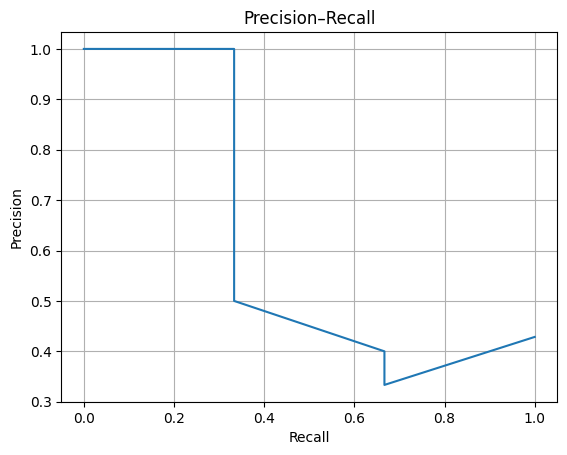

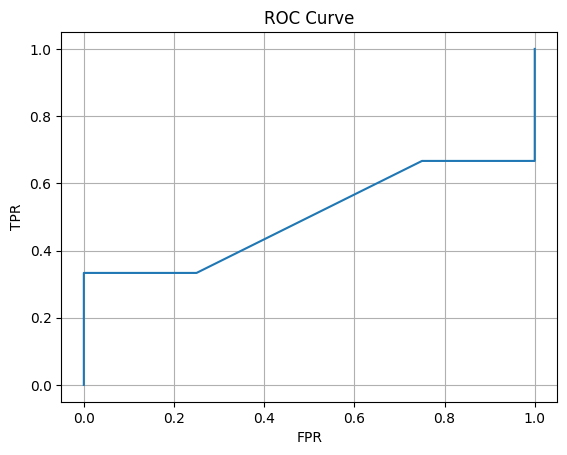


✅ Model saved at: /content/models_triangle/triangle_rf_model.joblib
✅ Meta info saved at: /content/models_triangle/meta.json

Contents of model_dir:
[PosixPath('models_triangle/meta.json'), PosixPath('models_triangle/triangle_rf_model.joblib')]


In [64]:
# STEP 4 — MODEL TRAINING, VALIDATION & EXPLAINABILITY (final fixed version)
# ================================================================================

import json, logging, warnings
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, classification_report, confusion_matrix
)
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import joblib

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# -----------------------------
# CONFIG
# -----------------------------
@dataclass
class TrainConfig:
    dataset_csv: Path = Path("./triangle_ml_dataset.csv")
    model_dir: Path   = Path("./models_triangle")
    test_ratio: float = 0.2
    cv_splits: int    = 3
    random_state: int = 42
    n_iter_search: int = 25
    cv_scoring: str   = "average_precision"  # good for imbalanced
    threshold_metric: str = "f1"
    base_model: str = "rf"                  # "rf" or "lr"

CFG = TrainConfig()

# -----------------------------
# LOAD & SPLIT
# -----------------------------
def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path.resolve()}")
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values(["symbol", "date"])
    logging.info(f"Loaded dataset {path} | shape={df.shape}")
    return df

def time_split(df: pd.DataFrame, test_ratio: float):
    # time-based split: hold out last X% by date
    cutoff = df["date"].quantile(1 - test_ratio)
    train_df = df[df["date"] <= cutoff].copy()
    test_df  = df[df["date"] >  cutoff].copy()
    logging.info(f"Time split → cutoff={cutoff.date()} | train={len(train_df)} | test={len(test_df)}")
    return train_df, test_df

# -----------------------------
# FEATURES
# -----------------------------
def build_feature_space(df: pd.DataFrame):
    if "target" not in df.columns:
        raise ValueError("Column 'target' missing in dataset")

    y = df["target"].astype(int)

    # Ensure categorical columns exist
    cat_cols = ["tri_type", "breakout_hint"]
    for c in cat_cols:
        if c not in df.columns:
            df[c] = ""

    # Numeric feature candidates = all numeric columns except identity/target
    drop = {"symbol", "date", "target"}
    num_cols = [c for c in df.columns
                if c not in drop.union(set(cat_cols))
                and np.issubdtype(df[c].dtype, np.number)]

    # Order features deterministically
    X = df[num_cols + cat_cols]
    groups = df["symbol"].astype(str).values
    return X, y, groups, num_cols, cat_cols

def make_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh",  OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])

# -----------------------------
# MODEL + SEARCH
# -----------------------------
def make_search_pipeline(base_model: str, random_state: int, n_iter: int,
                         cv, scoring: str):

    if base_model == "rf":
        clf = RandomForestClassifier(
            class_weight="balanced_subsample",
            random_state=random_state,
            n_jobs=-1
        )
        param_dist = {
            "clf__n_estimators":   [300, 500, 700],
            "clf__max_depth":      [None, 6, 10, 15],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf":  [1, 2, 4],
            "clf__max_features":   ["sqrt", "log2", 0.5],
        }
    else:
        clf = LogisticRegression(
            solver="saga", penalty="l2",
            class_weight="balanced",
            max_iter=5000, random_state=random_state
        )
        param_dist = {"clf__C": np.logspace(-3, 2, 20)}

    pipe = Pipeline([
        ("pre", "placeholder"),  # we will inject the real preprocessor later
        ("clf", clf)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,                # GroupKFold splitter object
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        refit=True,
        random_state=random_state
    )
    return search

# -----------------------------
# METRICS / EVAL
# -----------------------------
def choose_threshold(y_true, y_prob, method="f1") -> float:
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1s = 2 * prec * rec / (prec + rec + 1e-9)
    if len(thr) == 0 or len(f1s) == 0:
        return 0.5
    best_idx = int(np.nanargmax(f1s))
    return float(thr[min(best_idx, len(thr)-1)])

def evaluate(model, X, y, thr: float, label="TEST"):
    prob = model.predict_proba(X)[:, 1]
    pred = (prob >= thr).astype(int)
    print(f"\n=== {label} ===")
    print(f"Acc={accuracy_score(y, pred):.3f} | F1={f1_score(y, pred):.3f} | "
          f"ROC={roc_auc_score(y, prob):.3f} | PR={average_precision_score(y, prob):.3f}")
    print("\nClassification Report\n---------------------")
    print(classification_report(y, pred, digits=4))
    print("Confusion Matrix\n-----------------")
    print(confusion_matrix(y, pred))
    return prob

# -----------------------------
# TRAINING PIPELINE (RUNS NOW)
# -----------------------------
def run_training(cfg: TrainConfig):
    # 1) Load & split
    df = load_dataset(cfg.dataset_csv)
    train_df, test_df = time_split(df, cfg.test_ratio)

    # 2) Build features
    X_train, y_train, g_train, num_cols, cat_cols = build_feature_space(train_df)
    X_test,  y_test,  g_test,  _,        _        = build_feature_space(test_df)

    # 3) Preprocessor
    pre = make_preprocessor(num_cols, cat_cols)

    # 4) GroupKFold for both search and calibration
    n_groups = len(np.unique(g_train))
    n_splits = min(cfg.cv_splits, max(2, n_groups))  # at least 2 splits
    gkf = GroupKFold(n_splits=n_splits)

    # 5) Hyperparameter search (group-aware)
    search = make_search_pipeline(cfg.base_model, cfg.random_state,
                                  cfg.n_iter_search, cv=gkf,
                                  scoring=cfg.cv_scoring)
    search.estimator.set_params(pre=pre)

    logging.info("Starting RandomizedSearchCV …")
    # IMPORTANT: pass groups here for GroupKFold
    search.fit(X_train, y_train, groups=g_train)
    best_model = search.best_estimator_
    logging.info(f"Best params: {search.best_params_}")

    # 6) Probability calibration (group-aware via precomputed splits)
    # CalibratedClassifierCV doesn't accept groups directly, so we precompute splits.
    cal_splits = list(gkf.split(X_train, y_train, groups=g_train))
    calibrated = CalibratedClassifierCV(best_model, cv=cal_splits, method="isotonic")
    calibrated.fit(X_train, y_train)

    # 7) Threshold tuning on training (or a hold-out fold if you prefer)
    prob_tr = calibrated.predict_proba(X_train)[:, 1]
    thr = choose_threshold(y_train, prob_tr, cfg.threshold_metric)
    logging.info(f"Chosen decision threshold = {thr:.3f}")

    # 8) Evaluation
    _ = evaluate(calibrated, X_train, y_train, thr, "TRAIN")
    prob_te = evaluate(calibrated, X_test,  y_test,  thr, "TEST")

    # 9) Curves
    prec, rec, _ = precision_recall_curve(y_test, prob_te)
    plt.figure()
    plt.plot(rec, prec)
    plt.title("Precision–Recall")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True); plt.show()

    fpr, tpr, _ = roc_curve(y_test, prob_te)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True); plt.show()

    # 10) Save (robust, absolute path + confirmation)
    cfg.model_dir.mkdir(parents=True, exist_ok=True)
    model_path = (cfg.model_dir / "triangle_rf_model.joblib").resolve()
    meta_path  = (cfg.model_dir / "meta.json").resolve()
    joblib.dump(calibrated, model_path)
    with open(meta_path, "w") as f:
        json.dump({"threshold": float(thr)}, f, indent=2)

    print("\n✅ Model saved at:", model_path)
    print("✅ Meta info saved at:", meta_path)

    # Quick verify
    print("\nContents of model_dir:")
    print(list(cfg.model_dir.glob("*")))

# --- Run immediately in notebooks ---
run_training(CFG)


In [65]:
from pathlib import Path
print(list(Path("./models_triangle").glob("*")))



[PosixPath('models_triangle/meta.json'), PosixPath('models_triangle/triangle_rf_model.joblib')]


In [66]:
pip install shap


Loading model and dataset...
✅ Loaded dataset (36 samples, 13 features)
Using threshold = 0.667
🧠 Feature space after preprocessing: 16 features
Using model type for SHAP: RandomForestClassifier
Computing SHAP values... this might take a minute ⏳
✅ SHAP values computed successfully!


<Figure size 1000x600 with 0 Axes>

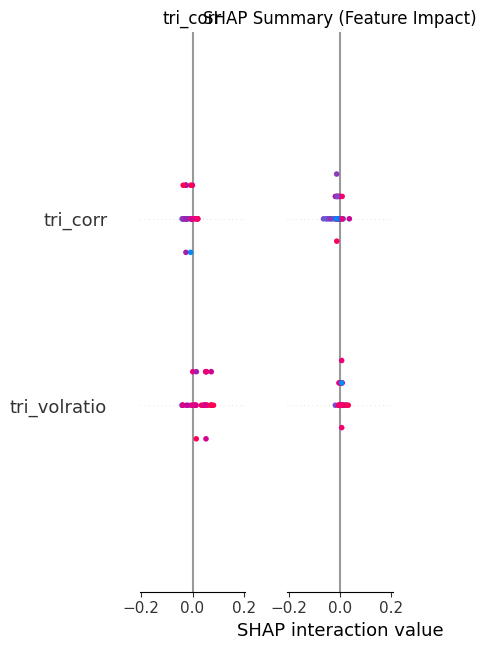

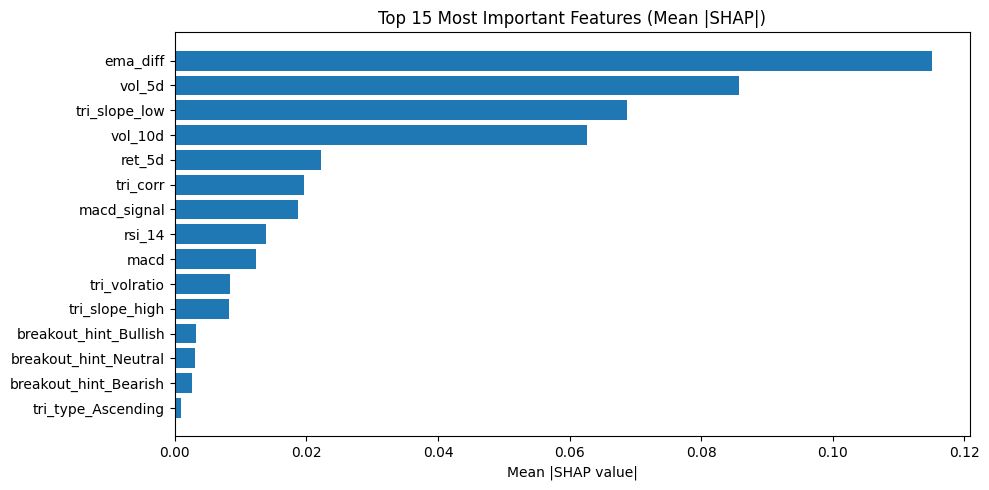


=== 🔍 Key Insights ===
 1. ema_diff             → importance=0.1150
 2. vol_5d               → importance=0.0857
 3. tri_slope_low        → importance=0.0687
 4. vol_10d              → importance=0.0626
 5. ret_5d               → importance=0.0222
 6. tri_corr             → importance=0.0197
 7. macd_signal          → importance=0.0188
 8. rsi_14               → importance=0.0139
 9. macd                 → importance=0.0123
10. tri_volratio         → importance=0.0084

🧠 Dominant drivers of model decisions: ema_diff, vol_5d, tri_slope_low, vol_10d, ret_5d
High SHAP magnitude = strong influence on predicted breakout direction.


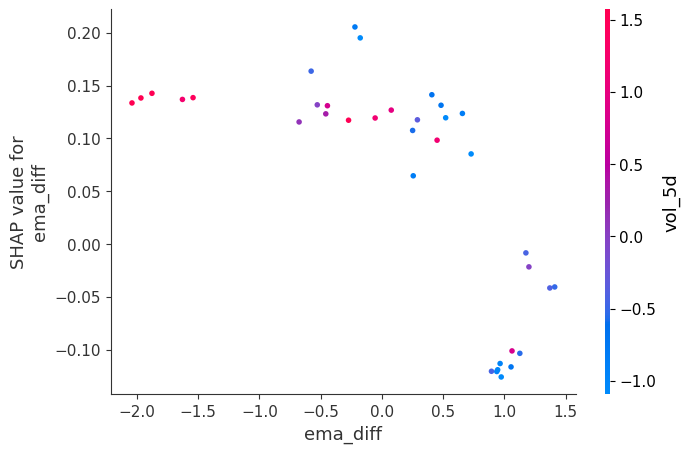

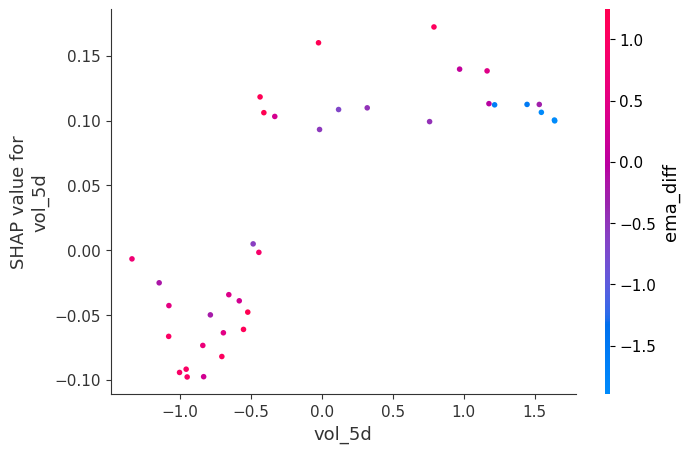

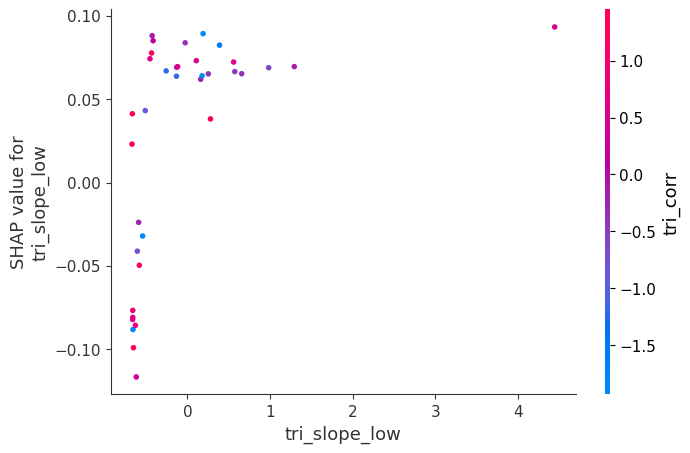

In [73]:
# STEP 5 — MODEL EXPLAINABILITY & FEATURE IMPORTANCE (final robust version)
# ======================================================================

import json, joblib, shap, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV

# -------------------------------------------------
# CONFIG
# -------------------------------------------------
MODEL_DIR = Path("./models_triangle")
DATASET_PATH = Path("./triangle_ml_dataset.csv")

# -------------------------------------------------
# 1️⃣ Load model and dataset
# -------------------------------------------------
print("Loading model and dataset...")
model = joblib.load(MODEL_DIR / "triangle_rf_model.joblib")
with open(MODEL_DIR / "meta.json") as f:
    meta = json.load(f)

df = pd.read_csv(DATASET_PATH, parse_dates=["date"])
X = df.drop(columns=["target", "symbol", "date"], errors="ignore")
y = df["target"]

print(f"✅ Loaded dataset ({df.shape[0]} samples, {X.shape[1]} features)")
print(f"Using threshold = {meta.get('threshold', 0.5):.3f}")

# -------------------------------------------------
# 2️⃣ Extract model components
# -------------------------------------------------
pre, clf = None, None

if isinstance(model, CalibratedClassifierCV):
    pipeline = model.estimator
    if isinstance(pipeline, Pipeline):
        pre = pipeline.named_steps.get("pre", None)
        clf = pipeline.named_steps.get("clf", None)
    else:
        clf = pipeline
elif isinstance(model, Pipeline):
    pre = model.named_steps.get("pre", None)
    clf = model.named_steps.get("clf", None)
else:
    clf = model

# reconstruct preprocessor if missing
if pre is None:
    num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    pre = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ])
    pre.fit(X)

if clf is None:
    raise RuntimeError("❌ Could not extract classifier from model")

# -------------------------------------------------
# 3️⃣ Extract post-transform feature names
# -------------------------------------------------
def get_feature_names(pre, X):
    if not isinstance(pre, ColumnTransformer):
        return X.columns.tolist()
    output = []
    for name, trans, cols in pre.transformers_:
        if hasattr(trans, "named_steps"):
            oh = trans.named_steps.get("oh")
            if isinstance(oh, OneHotEncoder):
                output.extend(oh.get_feature_names_out(cols))
            else:
                output.extend(cols)
        else:
            output.extend(cols)
    return output

feature_names = get_feature_names(pre, X)
print(f"🧠 Feature space after preprocessing: {len(feature_names)} features")

# -------------------------------------------------
# 4️⃣ SHAP explainability
# -------------------------------------------------
base_model = clf.base_estimator if hasattr(clf, "base_estimator") else clf
print(f"Using model type for SHAP: {type(base_model).__name__}")

if "Forest" in type(base_model).__name__ or "Tree" in type(base_model).__name__:
    explainer = shap.TreeExplainer(base_model)
else:
    explainer = shap.Explainer(base_model)

print("Computing SHAP values... this might take a minute ⏳")
X_transformed = pre.transform(X)
shap_values = explainer(X_transformed)
print("✅ SHAP values computed successfully!")

# --- Handle multi-class outputs
if isinstance(shap_values.values, list):
    shap_matrix = shap_values.values[1]  # class 1
elif shap_values.values.ndim == 3:
    shap_matrix = shap_values.values[:, :, 1]  # binary class 1
else:
    shap_matrix = shap_values.values

# --- Ensure shape consistency
n_features = shap_matrix.shape[1]
if len(feature_names) != n_features:
    print(f"⚠️ Adjusting feature names: SHAP={n_features}, names={len(feature_names)}")
    feature_names = feature_names[:n_features]

# -------------------------------------------------
# 5️⃣ Global Feature Importance
# -------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Feature Impact)")
plt.tight_layout()
plt.show()

# --- Mean absolute importance
imp = np.abs(shap_matrix).mean(axis=0)
imp_df = pd.DataFrame({"feature": feature_names, "importance": imp})
imp_df = imp_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(imp_df["feature"].head(15)[::-1], imp_df["importance"].head(15)[::-1])
plt.title("Top 15 Most Important Features (Mean |SHAP|)")
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 6️⃣ Insights
# -------------------------------------------------
print("\n=== 🔍 Key Insights ===")
for i, row in enumerate(imp_df.head(10).itertuples(), 1):
    print(f"{i:2d}. {row.feature:<20} → importance={row.importance:.4f}")

top_feats = imp_df.head(5)["feature"].tolist()
print(f"\n🧠 Dominant drivers of model decisions: {', '.join(top_feats)}")
print("High SHAP magnitude = strong influence on predicted breakout direction.")

# -------------------------------------------------
# 7️⃣ Dependence plots
# -------------------------------------------------
for feat in top_feats[:3]:
    shap.dependence_plot(feat, shap_matrix, X_transformed, feature_names=feature_names)
